In [1]:
import pandas as pd
import numpy as np
from numpy import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import *
from datetime import datetime as dt


# LOAD SENTIMENT DATA
-------------------------

In [2]:
#LOAD DATA
df = pd.read_csv('sentiment.csv', usecols=[1,7,8,9,10])
#CONVERT STRING DATES TO DATETIME OBJECTS
df.Date = pd.to_datetime(df.Date)
#DROP THE TIMESTAMP
df.Date = df.Date.dt.date
#SET DATE AS THE INDEX
df = df.set_index(pd.DatetimeIndex(df.Date))
print(df.shape)
df.head()

(289, 5)


,Date,Positive Sentiment,Negative Sentiment,Headline Positive,Headline Negative
Date,,,,,
2018-02-09,2018-02-09,0.272381,-0.030476,1,0
2018-02-07,2018-02-07,0.300000,-0.005556,2,0
2018-02-07,2018-02-07,0.222222,0.000000,1,0
2018-01-02,2018-01-02,0.540797,-0.011385,1,0
2018-01-14,2018-01-14,0.256410,-0.019231,0,0


The first thing we need to resolve is how to score dates that have more than one  Sentiment Score. This means there were several different articles parsed for that day. For instance, we can see below, September 8$^{th}$ had 4
different article parsed

In [3]:
df.sort_index().iloc[26:30]

,Date,Positive Sentiment,Negative Sentiment,Headline Positive,Headline Negative
Date,,,,,
2017-09-08,2017-09-08,0.368286,-0.002558,1,0
2017-09-08,2017-09-08,0.411765,0.000000,0,0
2017-09-08,2017-09-08,0.102857,-0.171429,0,0
2017-09-08,2017-09-08,0.102857,-0.171429,0,0


### Average
-----------------
The First thing we can do is average the values for each date

In [4]:
#GROUPBY DATES THEN AGGREGATE THE MEAN OF ALL VALUE(S) FOR EACH DATE
df_mean = df.groupby(df.index).mean()
print(df_mean.iloc[25])
df_mean.head()

Positive Sentiment    0.246441
Negative Sentiment   -0.086354
Headline Positive     0.250000
Headline Negative     0.000000
Name: 2017-09-08 00:00:00, dtype: float64


,Positive Sentiment,Negative Sentiment,Headline Positive,Headline Negative
Date,,,,
2013-12-19,0.140625,-0.020833,0.0,0.0
2017-05-16,0.187856,-0.034156,1.0,0.0
2017-05-26,0.461538,-0.004525,1.0,0.0
2017-06-07,0.181159,-0.007246,0.0,0.0
2017-06-21,0.175000,-0.056250,1.0,0.0


### Sum
-----------------
The Second thing we can do is sum the values for each date

In [5]:
#GROUPBY DATES THEN AGGREGATE THE SUM OF ALL VALUE(S) FOR EACH DATE
df_sum = df.groupby(df.index).sum()
print(df_sum.iloc[25])
df_sum.head()

Positive Sentiment    0.985765
Negative Sentiment   -0.345415
Headline Positive     1.000000
Headline Negative     0.000000
Name: 2017-09-08 00:00:00, dtype: float64


,Positive Sentiment,Negative Sentiment,Headline Positive,Headline Negative
Date,,,,
2013-12-19,0.140625,-0.020833,0,0
2017-05-16,0.187856,-0.034156,1,0
2017-05-26,0.461538,-0.004525,1,0
2017-06-07,0.181159,-0.007246,0,0
2017-06-21,0.175000,-0.056250,1,0


### Root Mean Squared
-------------------------
The Third thing we can do is take the root mean square of each value

In [6]:
#GROUPBY DATES THEN AGGREGATE THE RMS OF ALL VALUE(S) FOR EACH DATE
df_rms = df.groupby(df.index).agg(lambda x: np.sqrt(np.mean(x**2)))
print(df_rms.iloc[25])
df_rms.head()

Positive Sentiment    0.285633
Negative Sentiment    0.121225
Headline Positive     0.500000
Headline Negative     0.000000
Name: 2017-09-08 00:00:00, dtype: float64


,Positive Sentiment,Negative Sentiment,Headline Positive,Headline Negative
Date,,,,
2013-12-19,0.140625,0.020833,0.0,0.0
2017-05-16,0.187856,0.034156,1.0,0.0
2017-05-26,0.461538,0.004525,1.0,0.0
2017-06-07,0.181159,0.007246,0.0,0.0
2017-06-21,0.175000,0.056250,1.0,0.0


# LOAD HISTORICAL PRICE DATA

In [7]:
#LOAD PRICES DATA
#rows 1 & 2 of the CSV file are header rows
df2 = pd.read_csv('historical_pricing.csv', header = [0,1]).rename(columns = {'Unnamed: 0_level_1':'Date'}).iloc[1:,:]
#CONVERT DATE COLUMN TO DATETIME OBJECT AND SET AS INDEX
df2 = df2.set_index(pd.DatetimeIndex(df2.Coin.Date))
df2.head()


Coin      XRP                                          \
                  Date Change %    High     Low    Open   Price    Vol.   
Date                                                                      
2017-08-01  2017-08-01    9.57%  0.1850  0.1585  0.1630  0.1786  26.82M   
2017-08-02  2017-08-02   -4.59%  0.1800  0.1680  0.1786  0.1704  11.47M   
2017-08-03  2017-08-03    2.46%  0.1772  0.1688  0.1704  0.1746   4.59M   
2017-08-04  2017-08-04   -0.57%  0.1780  0.1710  0.1746  0.1736   7.21M   
2017-08-05  2017-08-05    5.99%  0.1920  0.1710  0.1736  0.1840  20.38M   

                BTC                                              ETH          \
           Change %    High     Low    Open   Price    Vol. Change %    High   
Date                                                                           
2017-08-01   -4.37%  2901.6  2615.8  2854.3  2731.2  42.31K   12.53%  232.59   
2017-08-02   -1.07%  2757.8  2640.0  2733.8  2702.0  23.76K   -3.53%  229.70   
2017-08-03    3.27%  2813.0  2698.0  2702.0  2790.3  16.86K    3.11%  228.20   
2017-08-04    2.50%  2874.8  2762.6  2790.3  2860.0  18.99K   -1.81%  228.30   
2017-08-05   13.86%  3331.9  2855.0  2860.0  3256.4  50.56K   15.01%  259.90   

                                             
               Low    Open   Price     Vol.  
Date                                         
2017-08-01  200.80  200.81  225.97  352.31K  
2017-08-02  215.00  225.97  218.00  159.47K  
2017-08-03  217.07  218.00  224.79   96.19K  
2017-08-04  218.66  224.79  220.73   83.46K  
2017-08-05  219.23  220.73  253.87  234.87K

# EDA

First let's check and see if there are any strong correlations between XRP price and all other price values as displayed in the table above

XRP  High     0.994777
     Low      0.990348
     Open     0.985908
     Price    1.000000
BTC  High     0.694890
     Low      0.701030
     Open     0.703973
     Price    0.693918
ETH  High     0.863066
     Low      0.862218
     Open     0.849802
     Price    0.870301
Name: Price, dtype: float64


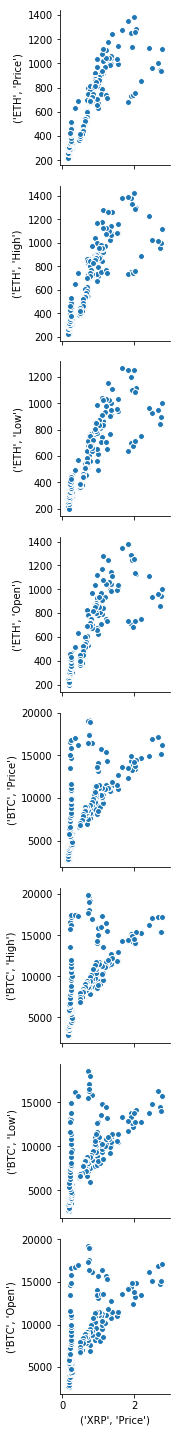

In [8]:
#CREATE CORRELATION MATRIX OF THE PRICES DATAFRAME
corr_matrix = df2.corr()
#EXTRACT CORRELATION VALUES FOR XRP PRICE
print(corr_matrix.XRP.Price)

sns.pairplot(df2, x_vars = [('XRP','Price')], y_vars = [('ETH','Price'),
                                                        ('ETH','High'),
                                                        ('ETH','Low'),
                                                        ('ETH','Open'),
                                                        ('BTC','Price'),
                                                        ('BTC','High'),
                                                        ('BTC','Low'),
                                                        ('BTC','Open')])
plt.show()

As we can see above, there's a good amount of correlation between XRP price and all the other price values. From the XRP standpoint, there's a higher correlation between XRP price and its intra day HIGH price. From ETH, the highest correlation between XRP price and ETH is from ETH's intra day trading price. And finally, with BTC - bitcoin, surpisingly the correlation isn't as strong as ETH since BTC is predominantly used to purchase XRP, but its highest correlation with XRP price is BTC open price. Let's now do some analysis on how XRP price fairs with our article sentiment.

--------------------------

To make things simpler, we need to first merge the sentiment dataframe with the prices dataframe. Keep in mind we have 3 different "combined metrics" of sentiment that we performed earlier {average sentiment, summed sentiment, RMS sentiment}. Instead of merging all into one big dataframe, we will operate on them one by one, starting with the "mean sentiment"

### Merge Mean Article Sentiment DF with XRP prices

In [9]:
#MERGE MEAN ARTICLE SENTIMENT DATAFRAME WITH XRP PRICE AND XRP PRICE CHANGE %
#perform full outer join
#drop all rows that don't have price data [price data starts at '2017-08-01']
df3_mean = pd.merge(df_mean,df2, how = 'outer', left_index = True, right_index = True).iloc[:,[0,1,2,3,4,5,9]].replace(np.NaN,0).iloc[7:-1]
df3_mean[('XRP', 'Change %')] = pd.to_numeric(df3_mean[('XRP', 'Change %')].str.replace('%','')).replace(np.NaN,0)
df3_mean.head()

/home/scott/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:558: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Positive Sentiment,Negative Sentiment,Headline Positive,Headline Negative,"(Coin, Date)","(XRP, Change %)","(XRP, Price)"
Date,,,,,,,
2017-08-01,0.000000,0.000000,0.0,0.0,2017-08-01,9.57,0.1786
2017-08-02,0.176871,-0.072562,0.0,0.0,2017-08-02,-4.59,0.1704
2017-08-03,0.000000,0.000000,0.0,0.0,2017-08-03,2.46,0.1746
2017-08-04,0.163616,-0.102975,0.0,0.0,2017-08-04,-0.57,0.1736
2017-08-05,0.000000,0.000000,0.0,0.0,2017-08-05,5.99,0.1840


Now that we have joined the desired data, let's create another correlation matrix to see how well the coin sentiment correlates to both XRP PRICE and XRP PRICE CHANGE %

In [10]:
#CREATE CORRELATION MATRIX
corr_matrix2 = df3_mean.corr()
print('****** Correlation Matrix for XRP PRICE *********')
print(corr_matrix2[('XRP', 'Price')])
print('\n')
print('****** Correlation Matrix for XRP %CHANGE *********')
print(corr_matrix2[('XRP','Change %')])



****** Correlation Matrix for XRP PRICE *********
Positive Sentiment    0.276289
Negative Sentiment   -0.184076
Headline Positive     0.209970
Headline Negative    -0.251495
(XRP, Change %)       0.063306
(XRP, Price)          1.000000
Name: (XRP, Price), dtype: float64


****** Correlation Matrix for XRP %CHANGE *********
Positive Sentiment    0.227740
Negative Sentiment    0.095674
Headline Positive     0.339030
Headline Negative     0.130113
(XRP, Change %)       1.000000
(XRP, Price)          0.063306
Name: (XRP, Change %), dtype: float64


Interestingly there's not too much correlation in either XRP Price nor XRP Price Change. However keep in mind, this is a linear correlation trend. There might be a quadratic, or higher order correlation. The quickest way to determine this is by visualizing the data. We will drop the Headline Sentiments for now and save them as extra features if needed

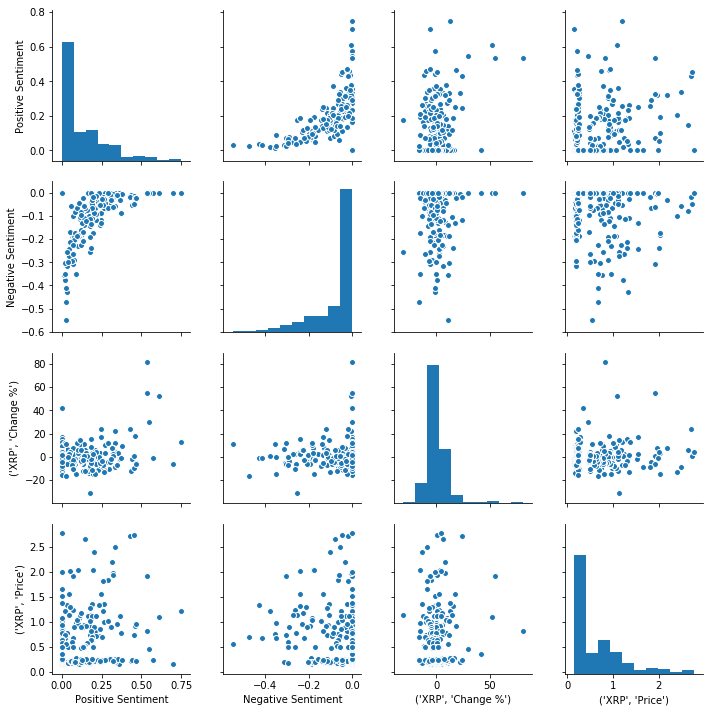

In [11]:
data = df3_mean.drop(('Coin','Date'),axis = 1).drop(['Headline Positive','Headline Negative'],axis = 1)
sns.pairplot(data)
plt.show()



There doesn't appear to be any quardatic or higher order correlation amongst the data. The above pair plot is a little busy, so let's focus more on the data we are interested in

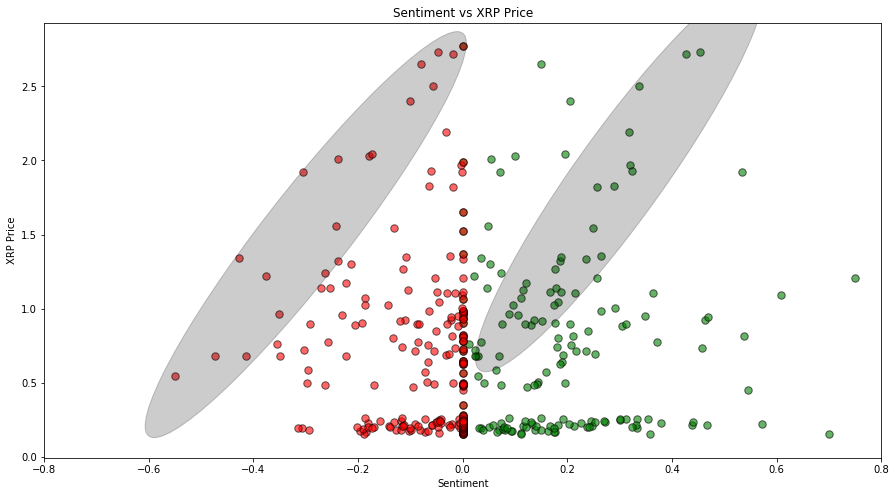

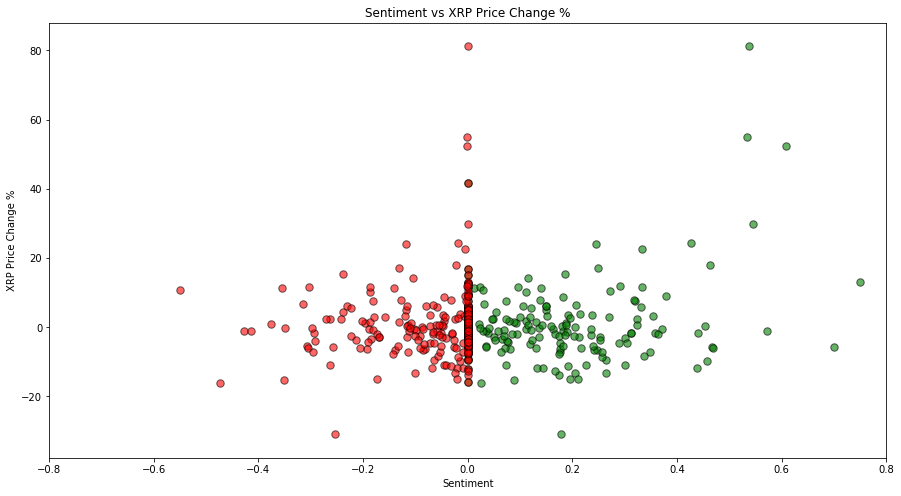

In [12]:
ax = df3_mean.plot(x = 'Positive Sentiment', y = ('XRP','Price'), kind = 'scatter', color = 'green', figsize = (15,8), alpha = 0.6, edgecolors='k',s=55)
df3_mean.plot(x = 'Negative Sentiment', y = ('XRP','Price'), kind = 'scatter', color = 'red', alpha = 0.6, edgecolors='k',s=55, ax = ax)
ax.set_title('Sentiment vs XRP Price')
ax.set_xlabel('Sentiment')
ax.set_ylabel('XRP Price')
ax.set_xlim([-0.8,0.8])

ax.add_patch(
    patches.Ellipse(
        (-0.3,1.5),   # (x,y)
        0.2,          # width
        2.8,          # height
        angle = 348,
        alpha = 0.2,
        color = 'k'
    ))

ax.add_patch(
    patches.Ellipse(
        (0.3,1.9),   # (x,y)
        0.2,          # width
        2.7,          # height
        angle = 349,
        alpha = 0.2,
        color = 'k'
    ))

plt.show()

ax = df3_mean.plot(x = 'Positive Sentiment', y = ('XRP','Change %'), kind = 'scatter', color = 'green', figsize = (15,8), alpha = 0.6, edgecolors='k',s=55)
df3_mean.plot(x = 'Negative Sentiment', y = ('XRP','Change %'), kind = 'scatter', color = 'red', alpha = 0.6, edgecolors='k',s=55, ax = ax)
ax.set_title('Sentiment vs XRP Price Change %')
ax.set_xlabel('Sentiment')
ax.set_ylabel('XRP Price Change %')
ax.set_xlim([-0.8,0.8])

plt.show()

We can now see that there isn't much of a correlation between the sentiments on their own vs XRP price or price chagne. However there is a noticeable negative trend on the negative sentiment side (with increasing negative sentiment the price decreases). Conversely there is a noticeable positive trend on the positive sentiment side as well. Each trend is highlighted in the top graph. The same trend lines appear in the "Sentiment vs XRP Price Change % graph as well. There's a few other things we can attempt, but probably our best shot would be combining the the negative and positive sentiment scores into some combined meaningful value. As we did earlier, we can combine them by averaging them or summing them together. Let's start by adding them

In [13]:
#CREATE A NEW COLUMN 
df3_mean['Overal Sentiment'] = df3_mean['Positive Sentiment'] + df3_mean['Negative Sentiment']

Next to keep everything standardized, lets normalize the XRP Price data to 1

In [14]:
from sklearn.preprocessing import MinMaxScaler
#INSTANTIATE A SCALER
scaler = MinMaxScaler()
#FIT THE SCALER TO THE DATA
scaler.fit(df3_mean[[('XRP','Price'),('XRP','Change %')]])
#TRANSFORM AND SCALE THE DATA - NORMALIZING IT TO 1
price_norm = scaler.transform(df3_mean[[('XRP','Price'),('XRP','Change %')]])

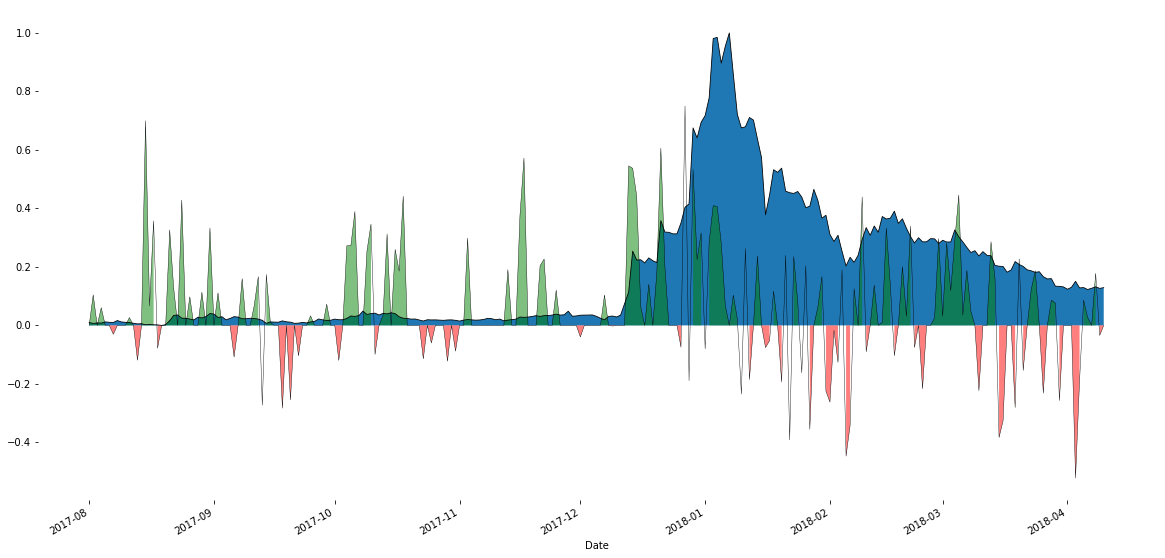

In [51]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.plot(df3_mean.index, price_norm[:,0], color = 'k', lw = 0.8)
ax.fill_between(df3_mean.index,np.zeros(len(price_norm)),price_norm[:,0],interpolate = True)

df3_mean['Overal Sentiment'].plot(color = 'k', lw = 0.4, ax = ax)
ax.fill_between(df3_mean.index,np.zeros(len(df3_mean)), df3_mean['Overal Sentiment'],where=(df3_mean['Overal Sentiment'] >= 0), facecolor='g', alpha = 0.5)
ax.fill_between(df3_mean.index,np.zeros(len(df3_mean)), df3_mean['Overal Sentiment'],where=(df3_mean['Overal Sentiment'] <= 0), facecolor='r', alpha = 0.5)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.show()



So we can see some pretty unique trends in the above graph, especially in where the peak of XRP begins its ascent. However I just realized a critical oversight. We want to see how the sentiment affects the price of XRP in the future. For example, maybe compare what impact yesterday's sentiment had on today's XRP price. Currently As graphed, the day's Price is also lined up with the day's sentiment. We can already see how it would look if we shifted the XRP up one so that yesterday's Sentiment reflects today's price. But let's go ahead and shift our data and regraph

In [29]:
shifted = df3_mean[[('XRP','Price'),('XRP','Change %')]].shift(-1).replace(np.NaN, 0)
shifted = scaler.transform(shifted)

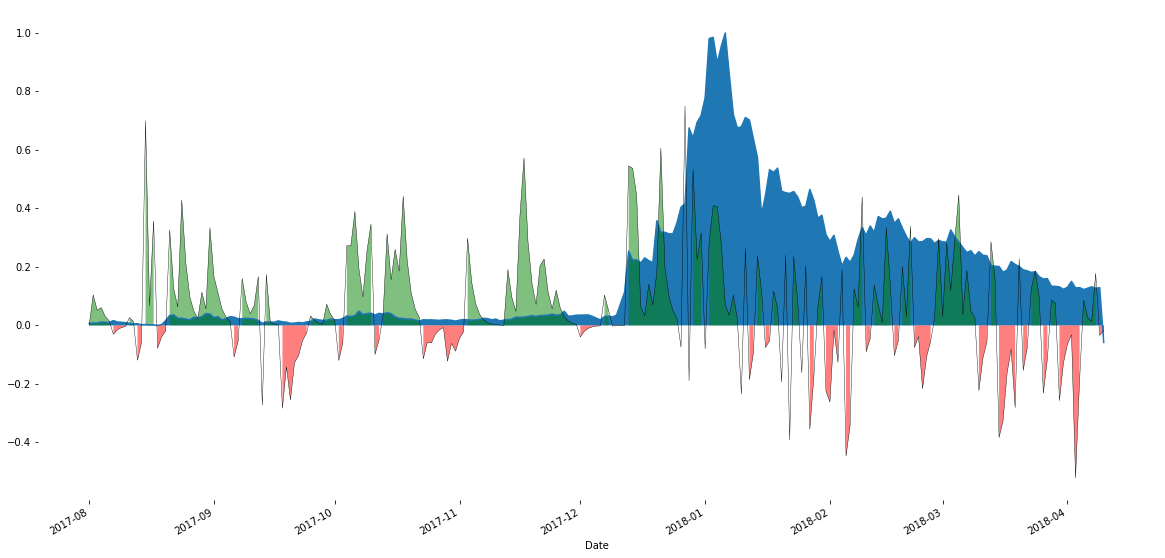

In [109]:
fig = plt.figure(figsize = (20,10))

ax = plt.subplot(111)
ax.plot(df3_mean.index, shifted[:,0])
ax.fill_between(df3_mean.index, np.zeros(len(df3_mean)), shifted[:,0])


df3_mean['Overal Sentiment'].plot(color = 'k', lw = 0.4, ax = ax)
ax.fill_between(df3_mean.index,np.zeros(len(df3_mean)), df3_mean['Overal Sentiment'],where=(df3_mean['Overal Sentiment'] >= 0), facecolor='g', alpha = 0.5)
ax.fill_between(df3_mean.index,np.zeros(len(df3_mean)), df3_mean['Overal Sentiment'],where=(df3_mean['Overal Sentiment'] <= 0), facecolor='r', alpha = 0.5)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.show()

Now that we have shifted the price data, we can see interesting enough that the previous days sentiment does bear affect on the following day's price in certain days. Again, we can see where the largest price peak's ascent begins, there's a pretty high sentiment value from the day before. However the sentiment is still all over the place. And maybe we can treat the sentiment in different manner. Let's say today there's several articles bearing high positive sentiment, but then the next day, there are no articles written, or maybe neutral articles written (sentiment of 0). That wouldn't necessarily deter an investor from investing today since the last bit of news bearing any sort of sentiment was high sentiment. Therefore there's still a pretty positive buzz surrounding our coin. Because of this, maybe we can alter a neutral day by taking in account its previous day's score.
> Score from 2 days ago = 3

> Score from yesterday = 0 

> forward fill and assume the sentiment from 2 days ago carried some of its positivity into the following day where sentiment was neutral

> Yesterday's NEW score is now 1/2 of its previous score = 1.5

Now let's keep the notion of forward filling 1/2 of the previous day's score. That way if there are multiple neutral day's in a row, whatever score was present before those neutral days would get forwarded to the first netural day and halved, then that score would get forwarded to the next neutral day and halved. This process will continue until a day with a non neutral score is reached.
### Example
--------------------
Daily Score Orig &nbsp; &nbsp; &nbsp; &nbsp; Daily Score Altered

10 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;10

0 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;5

0 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;2.5

3 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;3

In [136]:
def forwardfill(df, col):
    c = df.copy()
    c = c[col]
    for i in range(1,len(c)):
        if c[i] >= 0 and c[i-1] > 0:
            c[i] = c[i] + (c[i-1]/2.0)
        elif c[i] >= 0 and c[i-1] < 0:
            c[i] = np.mean((c[i],c[i-1]))
        elif c[i] <= 0 and c[i-1] < 0:
            c[i] = c[i] + (c[i-1]/2.0)
        else:
            c[i] = np.mean((c[i],c[i-1]))
            
    df['ffill_avg'] = c
    return df

In [166]:
def boxfilter(df,col):
    c = df.copy()
    c = c[col]
    d = c.copy()
    for i in range(4,len(c)):
        d[i] = np.mean((c[i],c[i-1],c[i-2],c[i-3],c[i-4]))
        
    df['box_filter']= d
    return df

In [167]:
test = boxfilter(df3_mean,'Overal Sentiment')
test.drop(['ffill','ffill_avg'],axis =1).head(12)

,Positive Sentiment,Negative Sentiment,Headline Positive,Headline Negative,"(Coin, Date)","(XRP, Change %)","(XRP, Price)",Overal Sentiment,box_filter
Date,,,,,,,,,
2017-08-01,0.000000,0.000000,0.0,0.0,2017-08-01,9.57,0.1786,0.000000,0.000000
2017-08-02,0.176871,-0.072562,0.0,0.0,2017-08-02,-4.59,0.1704,0.104308,0.104308
2017-08-03,0.000000,0.000000,0.0,0.0,2017-08-03,2.46,0.1746,0.052154,0.052154
2017-08-04,0.163616,-0.102975,0.0,0.0,2017-08-04,-0.57,0.1736,0.060641,0.060641
2017-08-05,0.000000,0.000000,0.0,0.0,2017-08-05,5.99,0.1840,0.030320,0.049485
2017-08-06,0.000000,0.000000,0.0,0.0,2017-08-06,-2.01,0.1803,0.015160,0.052517
2017-08-07,0.068871,-0.099174,0.0,0.0,2017-08-07,-0.72,0.1790,-0.030303,0.025594
2017-08-08,0.000000,0.000000,0.0,0.0,2017-08-08,9.44,0.1959,-0.015152,0.012133
2017-08-09,0.081081,-0.081081,0.0,0.0,2017-08-09,-6.38,0.1834,-0.007576,-0.001510


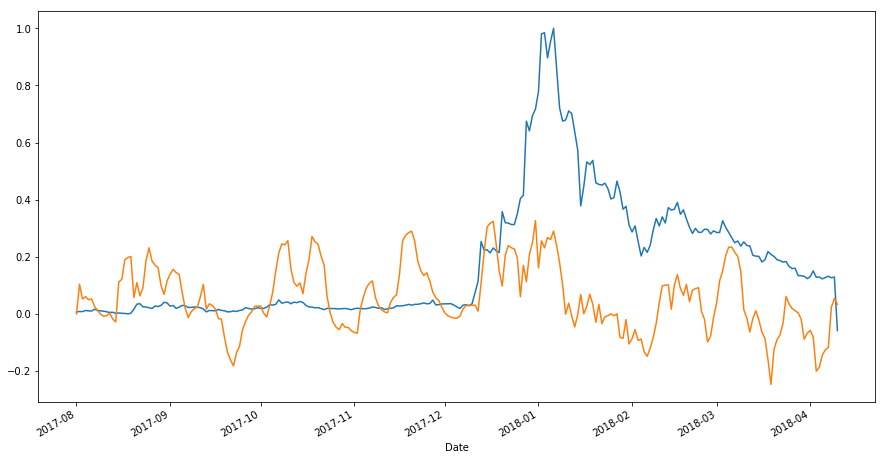

In [168]:
fig = plt.figure(figsize = (15,8))
ax = plt.subplot(111)
ax.plot(test.index, shifted[:,0])
test.box_filter.plot(ax = ax)

plt.show()

In [18]:
df3['% Change Binned'],bins = pd.cut(df3[('XRP','Change %')], bins = 20, labels = range(20),retbins=True)
print(bins)
df3.head(10)

NameError: name 'df3' is not defined

In [109]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

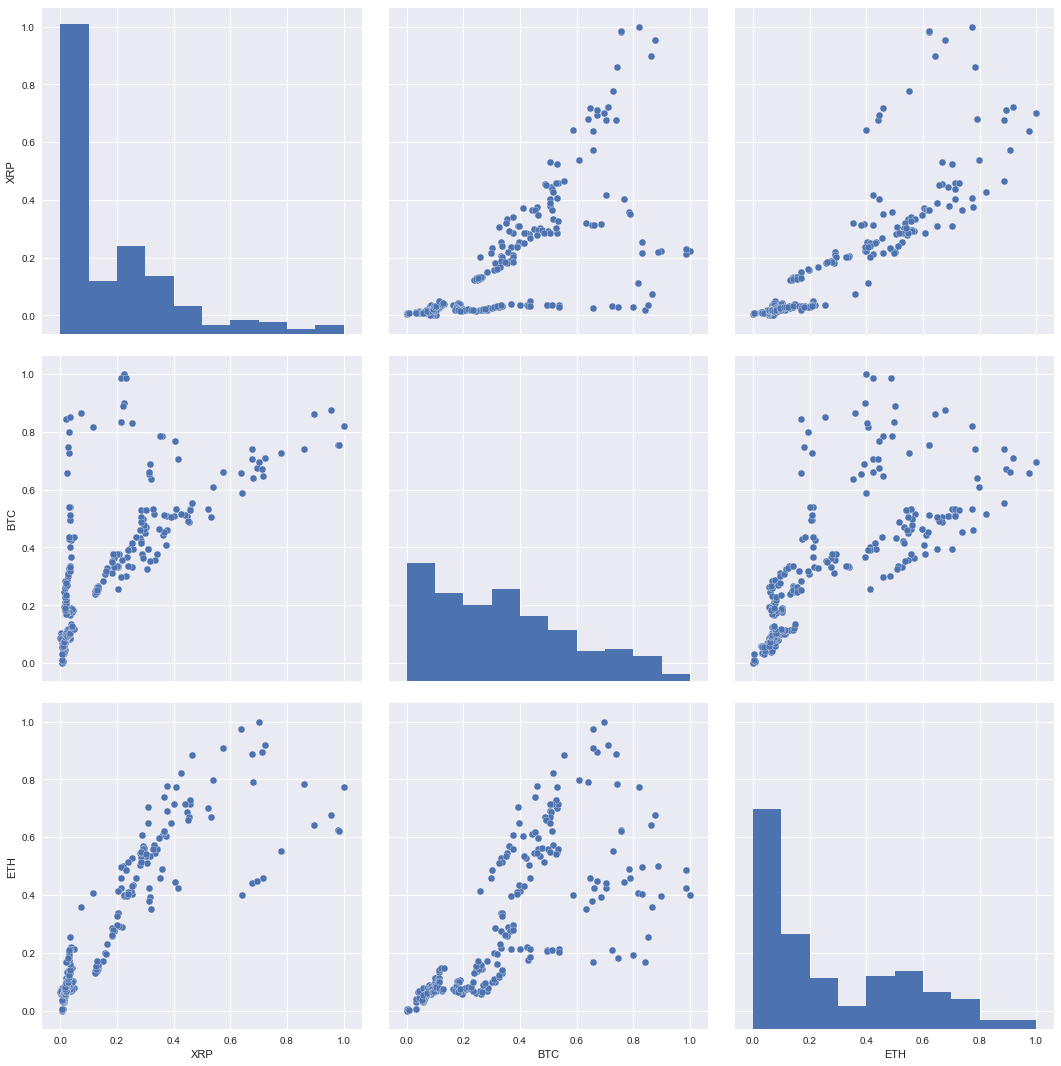

In [110]:
prices = df2.iloc[:,[5,11,17]]
scaler.fit(prices)
prices_scaled = scaler.transform(prices)
scaled_prices = pd.DataFrame(prices_scaled, columns = ['XRP','BTC','ETH'])
sns.pairplot(scaled_prices, size = 5)
plt.show()

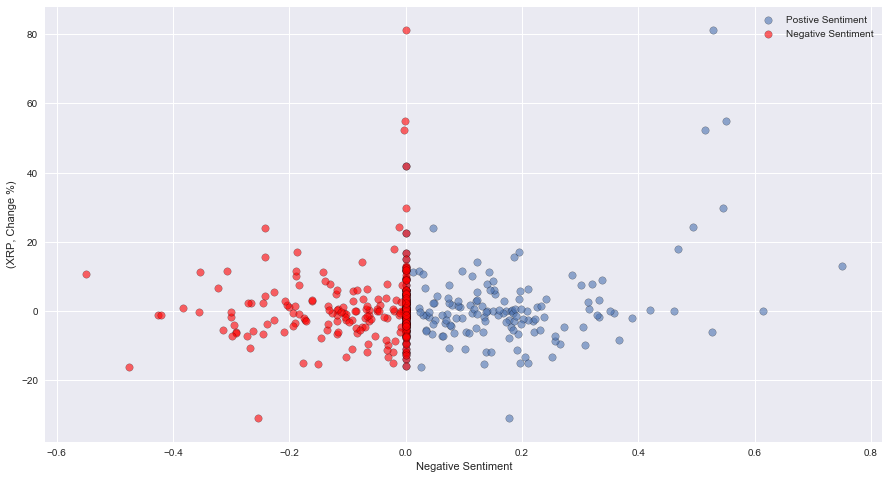

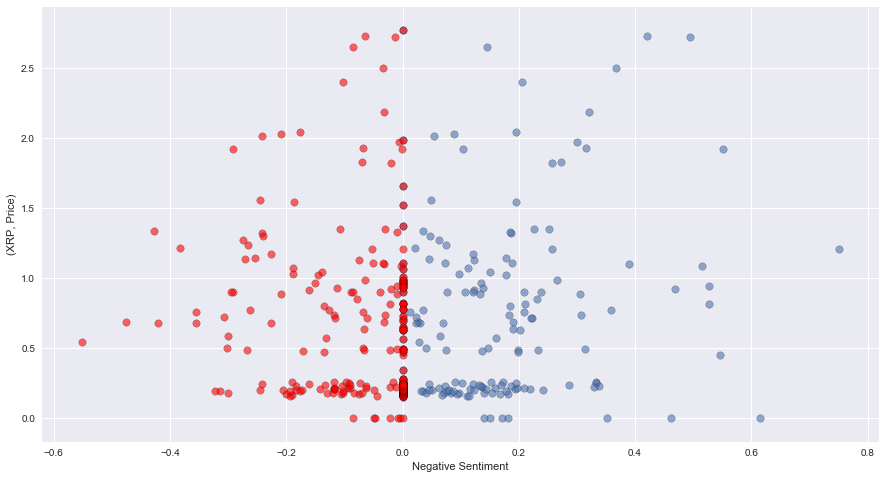

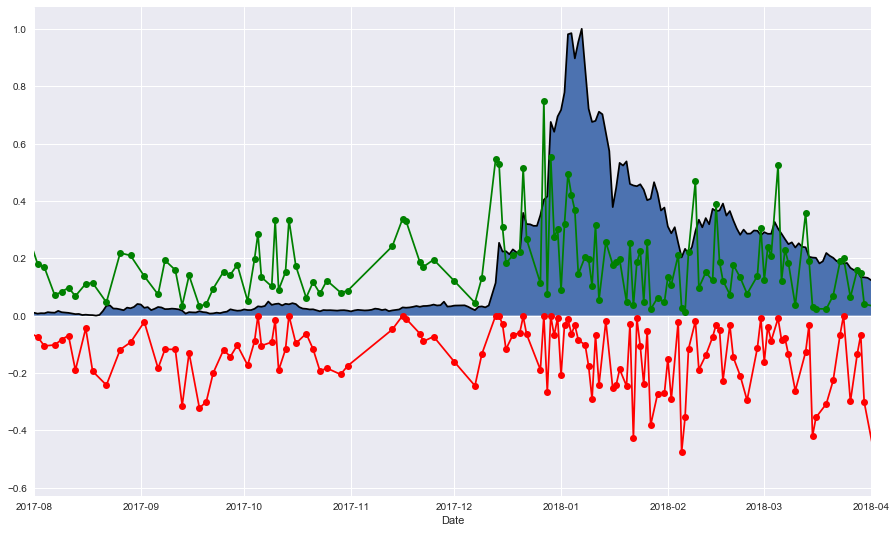

In [126]:

ax = df3.plot(x = 'Positive Sentiment', y = ('XRP', 'Change %'), kind = 'scatter', figsize = (15,8), alpha = 0.6, edgecolors='k',s=55)
df3.plot(x = 'Negative Sentiment', y = ('XRP','Change %'), kind = 'scatter', color = 'red', ax = ax, alpha = 0.6, edgecolors='k', s=55)
plt.legend(['Postive Sentiment', 'Negative Sentiment'])
ax2 = df3.plot(x = 'Positive Sentiment', y = ('XRP', 'Price'), kind = 'scatter', figsize = (15,8), alpha = 0.6, edgecolors='k',s=55)
df3.plot(x = 'Negative Sentiment', y = ('XRP','Price'), kind = 'scatter', color = 'red', ax = ax2, alpha = 0.6, edgecolors='k', s=55)
plt.show()

fig = plt.figure(figsize=(15,9))
plt.fill_between(df2.index,np.zeros(len(scaled_prices.XRP)),scaled_prices.XRP,interpolate = True)
plt.plot(df2.Coin.Date, scaled_prices.XRP, color = 'k')
df['Positive Sentiment'].plot(marker = 'o', linestyle = '-', color = 'green')
df['Negative Sentiment'].plot(marker = 'o', linestyle = '-', color = 'red')

x = ['2017-08','2018-04']


plt.xlim(x)
plt.show()

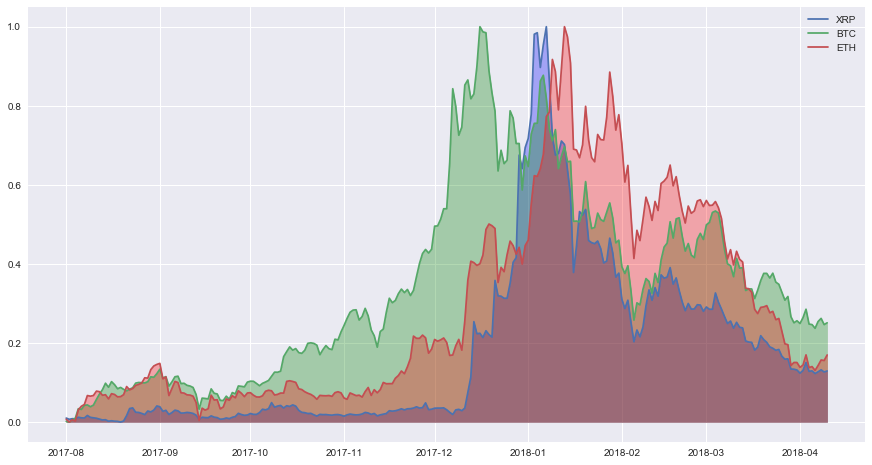

In [111]:
fig = plt.figure(figsize=(15,8))
plt.plot(df2.index, scaled_prices.XRP)
plt.fill_between(df2.index,0,scaled_prices.XRP, color = 'blue', alpha = 0.3)
plt.plot(df2.index, scaled_prices.BTC)
plt.fill_between(df2.index,0,scaled_prices.BTC, color = 'green', alpha = 0.3)
plt.plot(df2.index, scaled_prices.ETH)
plt.fill_between(df2.index,0,scaled_prices.ETH, color = 'red', alpha = 0.3)
plt.legend(['XRP','BTC','ETH'])
plt.show()

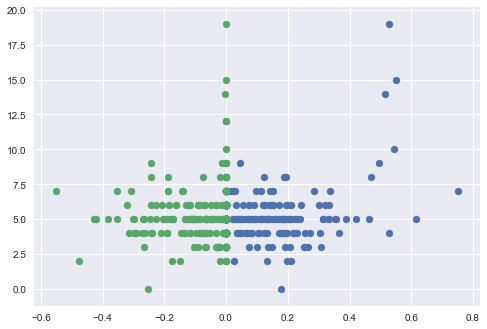

In [125]:
plt.scatter(df3['Positive Sentiment'],df3['% Change Binned'])
plt.scatter(df3['Negative Sentiment'],df3['% Change Binned'])
plt.show()